# Diagnostic Analytics - Root Cause Analysis

**Goal:** Conduct Root cause analysis to understand why some pattern exists.

**Questions from Descriptive Analytics Notebook:**
- Why Retention is low? (only 3%)
- Why delays are okay in some category?
- Why geographic location matter?
- What is driving poor reviews apart from delays?

In [1]:
# Setup, Imports, Settings, & Db Connection
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

conn = sqlite3.connect('../data/ecommerce.db')


### 1. Retention Problem - Root Cause Analysis

#### 1.1 Platform Model Analysis

- Hypothesis - Its a marketplace & Ppl buy from sellers not platform - Need to check seller diversity

In [4]:
seller_diversity_query = """
SELECT 
    c.customer_unique_id,
    COUNT(DISTINCT o.order_id) as num_orders,
    COUNT(DISTINCT oi.seller_id) as num_unique_sellers,
    ROUND(AVG(oi.price + oi.freight_value), 2) as avg_order_value
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_unique_id
HAVING num_orders > 1
"""

repeat_customers = pd.read_sql(seller_diversity_query, conn)

print(f"Repeat Customers Analysis (n = {len(repeat_customers):,}):")
print(f"\nSeller Diversity Among Repeat Customers:")
print(f"  Avg orders per repeat customer: {repeat_customers['num_orders'].mean():.2f}")
print(f"  Avg unique sellers per customer: {repeat_customers['num_unique_sellers'].mean():.2f}")
print(f"  % using same seller: {(repeat_customers['num_orders'] == repeat_customers['num_unique_sellers']).mean() * 100:.1f}%")

print("\n INSIGHT:")
if repeat_customers['num_orders'].mean() - repeat_customers['num_unique_sellers'].mean() < 0.5:
    print("  Even repeat customers use DIFFERENT sellers each time!")
    print("  This confirms: No seller loyalty -> No platform loyalty")
else:
    print("  Repeat customers tend to stick with same sellers")
    print("  Opportunity: Build seller-specific loyalty")

Repeat Customers Analysis (n = 2,801):

Seller Diversity Among Repeat Customers:
  Avg orders per repeat customer: 2.11
  Avg unique sellers per customer: 1.84
  % using same seller: 66.9%

 INSIGHT:
  Even repeat customers use DIFFERENT sellers each time!
  This confirms: No seller loyalty -> No platform loyalty


#### 1.2 Product Mix: One-Off vs Repeat Purchase Categories


Overall Average Repeat Purchase Rate Across Categories: 1.01%
Categories with HIGHEST Repeat Purchase Rates:
                   category  total_customers  repeat_buyers  repeat_rate_pct
0           home_appliances              688             50             7.27
1  fashion_bags_accessories             1757             52             2.96
2            bed_bath_table             9008            245             2.72
3            sports_leisure             7341            170             2.32
4           furniture_decor             6178            126             2.04
5     fashion_male_clothing              104              2             1.92
6     computers_accessories             6405            119             1.86
7                    drinks              282              5             1.77
8     furniture_living_room              407              7             1.72
9             health_beauty             8498            142             1.67

Categories with LOWEST Repeat Purchase Rat

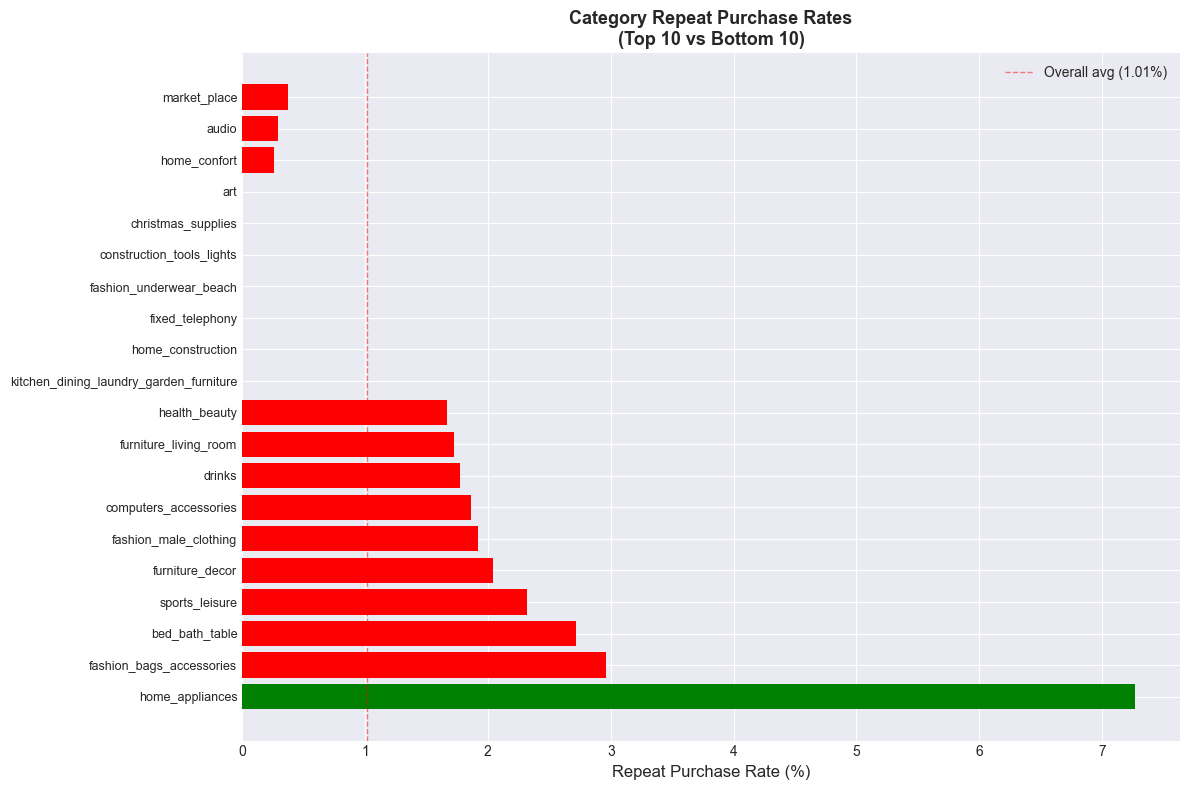

In [8]:
# Categories having low repeat rates:
category_repeat_query = """
WITH customer_category_purchases AS (
    SELECT 
        c.customer_unique_id,
        COALESCE(pct.product_category_name_english, p.product_category_name, 'Unknown') as category,
        COUNT(DISTINCT o.order_id) as purchases_in_category
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    JOIN products p ON oi.product_id = p.product_id
    LEFT JOIN product_category_name_translation pct 
        ON p.product_category_name = pct.product_category_name
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_unique_id, category
)
SELECT 
    category,
    COUNT(DISTINCT customer_unique_id) as total_customers,
    SUM(CASE WHEN purchases_in_category > 1 THEN 1 ELSE 0 END) as repeat_buyers,
    ROUND(SUM(CASE WHEN purchases_in_category > 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT customer_unique_id), 2) as repeat_rate_pct
FROM customer_category_purchases
GROUP BY category
HAVING total_customers >= 100
ORDER BY repeat_rate_pct DESC
"""

category_repeat = pd.read_sql(category_repeat_query, conn)

# Overall Average
overall_repeat_rate = category_repeat['repeat_rate_pct'].mean()
print(f"\nOverall Average Repeat Purchase Rate Across Categories: {overall_repeat_rate:.2f}%")

print("Categories with HIGHEST Repeat Purchase Rates:")
print(category_repeat.head(10))

print("\nCategories with LOWEST Repeat Purchase Rates:")
print(category_repeat.tail(10))


# Charts
fig, ax = plt.subplots(figsize=(12, 8))

top_bottom = pd.concat([
    category_repeat.nlargest(10, 'repeat_rate_pct'),
    category_repeat.nsmallest(10, 'repeat_rate_pct')
])

colors = ['green' if x > 5 else 'orange' if x > 3 else 'red' for x in top_bottom['repeat_rate_pct']]
ax.barh(range(len(top_bottom)), top_bottom['repeat_rate_pct'], color=colors)
ax.set_yticks(range(len(top_bottom)))
ax.set_yticklabels(top_bottom['category'], fontsize=9)
ax.set_xlabel('Repeat Purchase Rate (%)', fontsize=12)
ax.set_title('Category Repeat Purchase Rates\n(Top 10 vs Bottom 10)', fontsize=13, fontweight='bold')
ax.axvline(overall_repeat_rate, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Overall avg ({overall_repeat_rate:.2f}%)')
ax.legend()

plt.tight_layout()
plt.savefig('../reports/figures/category_repeat_rates.png', dpi=300, bbox_inches='tight')
plt.show()


### 2. Delivery Performance Deep Dive

#### 2.1 Customer - Seller Distance Impact

In [10]:
distance_query = """
WITH order_geography AS (
    SELECT 
        o.order_id,
        c.customer_state,
        s.seller_state,
        CASE 
            WHEN c.customer_state = s.seller_state THEN 'Same State'
            ELSE 'Different State'
        END as location_match,
        JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_purchase_timestamp) as delivery_days,
        JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_estimated_delivery_date) as delay_days,
        r.review_score
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    JOIN sellers s ON oi.seller_id = s.seller_id
    LEFT JOIN order_reviews r ON o.order_id = r.order_id
    WHERE o.order_status = 'delivered'
      AND o.order_delivered_customer_date IS NOT NULL
)
SELECT 
    location_match,
    COUNT(*) as num_orders,
    ROUND(AVG(delivery_days), 2) as avg_delivery_days,
    ROUND(AVG(delay_days), 2) as avg_delay_days,
    ROUND(AVG(review_score), 2) as avg_review_score,
    ROUND(SUM(CASE WHEN delay_days > 0 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as delay_rate_pct
FROM order_geography
GROUP BY location_match
ORDER BY num_orders DESC
"""

distance_impact = pd.read_sql(distance_query, conn)

print("Impact of Customer-Seller Geographic Distance:")
print(distance_impact)

# Calculate the impact
if len(distance_impact) == 2:
    same_state = distance_impact[distance_impact['location_match'] == 'Same State'].iloc[0]
    diff_state = distance_impact[distance_impact['location_match'] == 'Different State'].iloc[0]
    
    print("\n KEY FINDINGS:")
    print(f"  Delivery time difference: {diff_state['avg_delivery_days'] - same_state['avg_delivery_days']:.1f} days longer for different state")
    print(f"  Delay rate difference: {diff_state['delay_rate_pct'] - same_state['delay_rate_pct']:.1f}% more delays")
    print(f"  Review impact: {diff_state['avg_review_score'] - same_state['avg_review_score']:.2f} stars")

Impact of Customer-Seller Geographic Distance:
    location_match  num_orders  avg_delivery_days  avg_delay_days  \
0  Different State       70748              15.05          -12.22   
1       Same State       40084               7.93           -9.78   

   avg_review_score  delay_rate_pct  
0              4.02            9.00  
1              4.20            5.95  

 KEY FINDINGS:
  Delivery time difference: 7.1 days longer for different state
  Delay rate difference: 3.0% more delays
  Review impact: -0.18 stars


#### 2.2 Top Routes (Customer <> Seller State)

Top 20 Customer-Seller Routes:
       route  num_orders  avg_delivery_days  avg_review  delay_rate
0   SP <> SP       30829               7.93        4.18        6.08
1   RJ <> SP        8188              16.11        3.79       14.82
2   MG <> SP        7469              12.29        4.07        6.09
3   RS <> SP        3613              16.03        4.02        7.29
4   PR <> SP        3130              12.78        4.08        5.18
5   SP <> PR        2959              11.14        4.19        3.65
6   SP <> MG        2578              10.90        4.17        4.05
7   SC <> SP        2336              15.85        3.93       10.58
8   BA <> SP        2313              19.75        3.80       14.82
9   MG <> MG        1539               8.64        4.31        3.04
10  ES <> SP        1467              15.72        3.98       14.01
11  GO <> SP        1424              15.75        3.99        8.80
12  DF <> SP        1386              13.20        4.00        8.50
13  SP <> RJ     

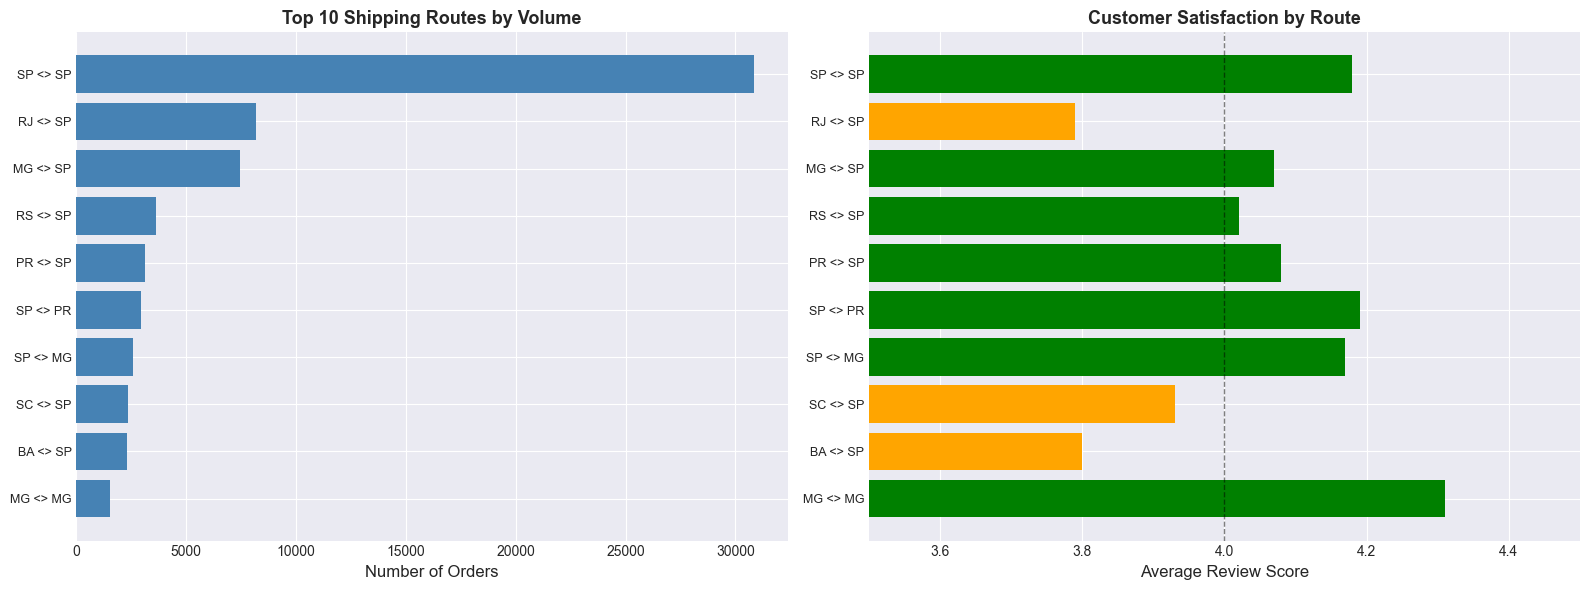

In [13]:
# Detailed route analysis
route_query = """
SELECT 
    c.customer_state as customer_state,
    s.seller_state as seller_state,
    COUNT(DISTINCT o.order_id) as num_orders,
    ROUND(AVG(JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_purchase_timestamp)), 2) as avg_delivery_days,
    ROUND(AVG(r.review_score), 2) as avg_review,
    ROUND(SUM(CASE WHEN JULIANDAY(o.order_delivered_customer_date) > JULIANDAY(o.order_estimated_delivery_date) THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as delay_rate
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
JOIN sellers s ON oi.seller_id = s.seller_id
LEFT JOIN order_reviews r ON o.order_id = r.order_id
WHERE o.order_status = 'delivered'
  AND o.order_delivered_customer_date IS NOT NULL
GROUP BY c.customer_state, s.seller_state
HAVING num_orders >= 50
ORDER BY num_orders DESC
LIMIT 20
"""

routes = pd.read_sql(route_query, conn)
routes['route'] = routes['customer_state'] + ' <> ' + routes['seller_state']

print("Top 20 Customer-Seller Routes:")
print(routes[['route', 'num_orders', 'avg_delivery_days', 'avg_review', 'delay_rate']])

#Charts for routes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top routes by volume
top_10 = routes.head(10)
axes[0].barh(range(len(top_10)), top_10['num_orders'], color='steelblue')
axes[0].set_yticks(range(len(top_10)))
axes[0].set_yticklabels(top_10['route'], fontsize=9)
axes[0].set_xlabel('Number of Orders', fontsize=12)
axes[0].set_title('Top 10 Shipping Routes by Volume', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()

# Delivery performance
colors_perf = ['green' if x >= 4.0 else 'orange' if x >= 3.5 else 'red' for x in top_10['avg_review']]
axes[1].barh(range(len(top_10)), top_10['avg_review'], color=colors_perf)
axes[1].set_yticks(range(len(top_10)))
axes[1].set_yticklabels(top_10['route'], fontsize=9)
axes[1].set_xlabel('Average Review Score', fontsize=12)
axes[1].set_title('Customer Satisfaction by Route', fontsize=13, fontweight='bold')
axes[1].axvline(4.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].invert_yaxis()
axes[1].set_xlim(3.5, 4.5)

plt.tight_layout()
plt.savefig('../reports/figures/shipping_routes_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### 3. Category Delay Sensitivity

#### 3.1 Which Category has the Most Delays

MOST Delay-Sensitive Categories (biggest review drop):
                                   category  total_orders  avg_price  \
0                   fashion_underwear_beach           116      73.46   
1                       musical_instruments           605     281.26   
2                     fashion_male_clothing           105      82.72   
3                         home_appliances_2           226     465.57   
4                                     audio           345     140.23   
5                          air_conditioning           242     185.31   
6   kitchen_dining_laundry_garden_furniture           239     166.47   
7                             fashion_shoes           231      89.09   
8                                 computers           174    1071.02   
9                                      toys          3773     116.65   
10                               stationery          2251      90.68   
11                                     baby          2787     134.03   
12       

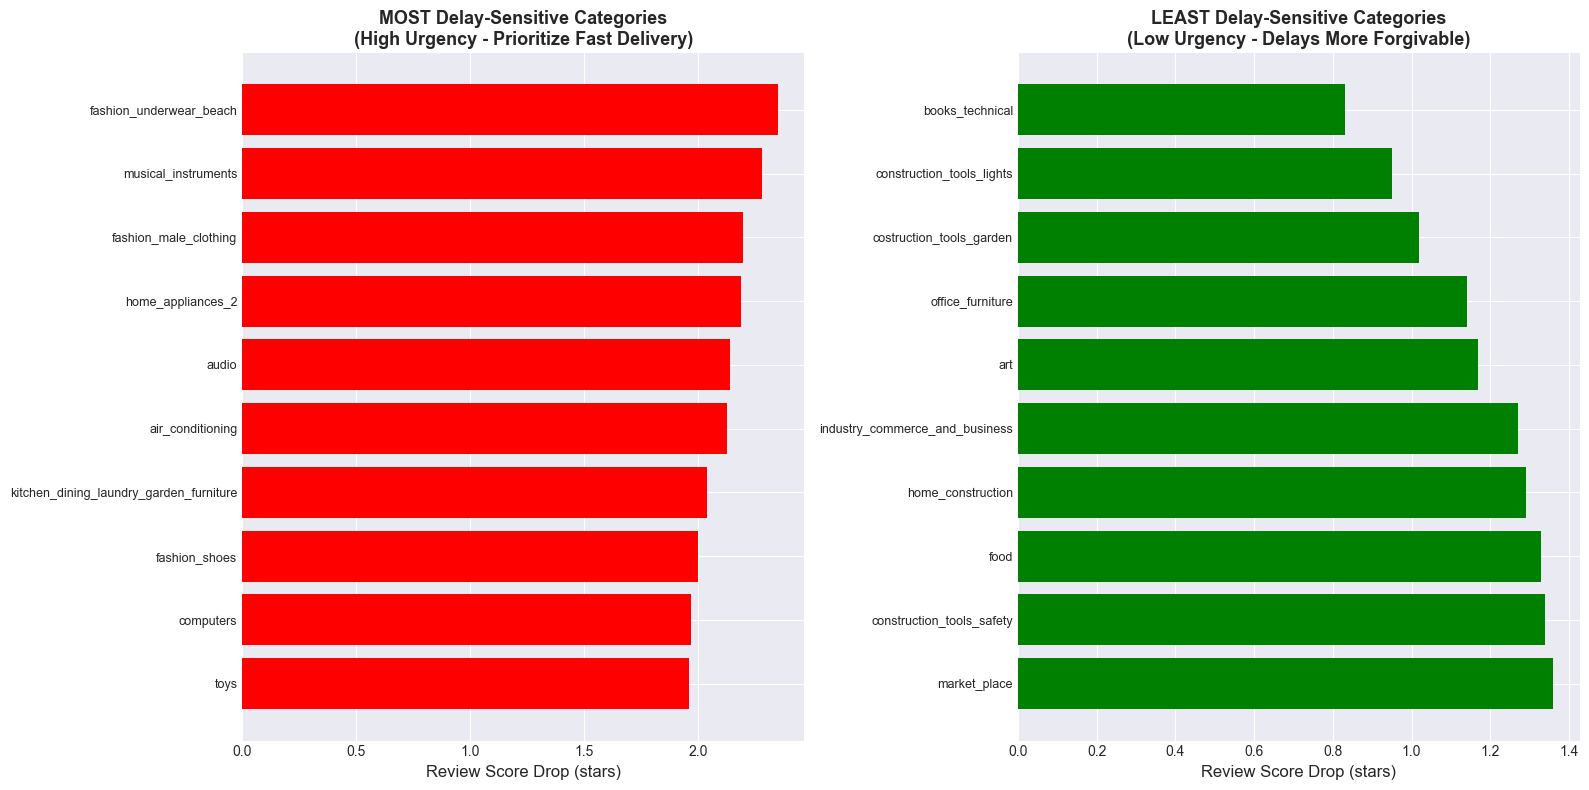

In [15]:
delay_sensitivity_query = """
SELECT 
    COALESCE(pct.product_category_name_english, p.product_category_name, 'Unknown') as category,
    COUNT(DISTINCT oi.order_id) as total_orders,
    ROUND(AVG(oi.price), 2) as avg_price,
    
    -- On-time performance
    ROUND(AVG(CASE 
        WHEN JULIANDAY(o.order_delivered_customer_date) <= JULIANDAY(o.order_estimated_delivery_date) 
        THEN r.review_score 
    END), 2) as avg_review_ontime,
    
    -- Delayed performance
    ROUND(AVG(CASE 
        WHEN JULIANDAY(o.order_delivered_customer_date) > JULIANDAY(o.order_estimated_delivery_date) 
        THEN r.review_score 
    END), 2) as avg_review_delayed,
    
    -- Calculate sensitivity (review drop from delays)
    ROUND(
        AVG(CASE WHEN JULIANDAY(o.order_delivered_customer_date) <= JULIANDAY(o.order_estimated_delivery_date) THEN r.review_score END) -
        AVG(CASE WHEN JULIANDAY(o.order_delivered_customer_date) > JULIANDAY(o.order_estimated_delivery_date) THEN r.review_score END),
        2
    ) as review_drop_from_delay
    
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
LEFT JOIN product_category_name_translation pct ON p.product_category_name = pct.product_category_name
JOIN orders o ON oi.order_id = o.order_id
LEFT JOIN order_reviews r ON o.order_id = r.order_id
WHERE o.order_status = 'delivered'
  AND o.order_delivered_customer_date IS NOT NULL
  AND r.review_score IS NOT NULL
GROUP BY category
HAVING total_orders >= 100
ORDER BY review_drop_from_delay DESC
"""

delay_sensitivity = pd.read_sql(delay_sensitivity_query, conn)

print("MOST Delay-Sensitive Categories (biggest review drop):")
print(delay_sensitivity.head(15))

print("\nLEAST Delay-Sensitive Categories (smallest review drop):")
print(delay_sensitivity.tail(15))

#Plots

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Most sensitive
most_sensitive = delay_sensitivity.nlargest(10, 'review_drop_from_delay')
axes[0].barh(range(len(most_sensitive)), most_sensitive['review_drop_from_delay'], color='red')
axes[0].set_yticks(range(len(most_sensitive)))
axes[0].set_yticklabels(most_sensitive['category'], fontsize=9)
axes[0].set_xlabel('Review Score Drop (stars)', fontsize=12)
axes[0].set_title('MOST Delay-Sensitive Categories\n(High Urgency - Prioritize Fast Delivery)', 
                 fontsize=13, fontweight='bold')
axes[0].invert_yaxis()

# Least sensitive
least_sensitive = delay_sensitivity.nsmallest(10, 'review_drop_from_delay')
axes[1].barh(range(len(least_sensitive)), least_sensitive['review_drop_from_delay'], color='green')
axes[1].set_yticks(range(len(least_sensitive)))
axes[1].set_yticklabels(least_sensitive['category'], fontsize=9)
axes[1].set_xlabel('Review Score Drop (stars)', fontsize=12)
axes[1].set_title('LEAST Delay-Sensitive Categories\n(Low Urgency - Delays More Forgivable)', 
                 fontsize=13, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/figures/category_delay_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()

#### 3.2 Hypothesis - Urgency

In [21]:
# Classify categories into urgency levels based on delay sensitivity
def classify_urgency(category):
    high_urgency = ['gifts', 'party', 'christmas', 'valentines', 'fashion', 'telephony']
    low_urgency = ['health_beauty', 'furniture', 'home', 'garden', 'construction']
    
    cat_lower = category.lower()
    if any(word in cat_lower for word in high_urgency):
        return '1. High Urgency'
    elif any(word in cat_lower for word in low_urgency):
        return '2. Low Urgency'
    else:
        return '3. Medium Urgency'

delay_sensitivity['Urgency_Class'] = delay_sensitivity['category'].apply(classify_urgency)

urgency_comparison = delay_sensitivity.groupby('Urgency_Class').agg({
    'category': 'count',
    'review_drop_from_delay': 'mean',
    'avg_price': 'mean'
}).round(2)

urgency_comparison.columns = ['Num_Categories', 'Avg_Review_Drop', 'Avg_Price']

print("Urgency Hypothesis Test:")
print(urgency_comparison)

print("\nCONCLUSION:")
if urgency_comparison.loc['1. High Urgency', 'Avg_Review_Drop'] > urgency_comparison.loc['2. Low Urgency', 'Avg_Review_Drop']:
    print("HYPOTHESIS CONFIRMED!")
    print("  1. High urgency items suffer MORE from delays")
    print("  2. Should prioritize fast shipping for gifts, fashion, events")
else:
    print("Hypothesis not supported by data")
    print("  Other factors may be more important than urgency")

Urgency Hypothesis Test:
                   Num_Categories  Avg_Review_Drop  Avg_Price
Urgency_Class                                                
1. High Urgency                 8             1.87     107.72
2. Low Urgency                 14             1.51     159.87
3. Medium Urgency              30             1.66     160.23

CONCLUSION:
HYPOTHESIS CONFIRMED!
  1. High urgency items suffer MORE from delays
  2. Should prioritize fast shipping for gifts, fashion, events


### 4. Seller Performance Analysis

#### 4.1 Sellers - Best vs Worst

In [23]:
seller_perf_query = """
SELECT 
    s.seller_id,
    s.seller_state,
    COUNT(DISTINCT o.order_id) as total_orders,
    ROUND(AVG(oi.price), 2) as avg_price,
    ROUND(SUM(oi.price + oi.freight_value), 2) as total_revenue,
    ROUND(AVG(r.review_score), 2) as avg_review,
    ROUND(AVG(JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_purchase_timestamp)), 2) as avg_delivery_days,
    ROUND(SUM(CASE WHEN JULIANDAY(o.order_delivered_customer_date) > JULIANDAY(o.order_estimated_delivery_date) THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as delay_rate
FROM sellers s
JOIN order_items oi ON s.seller_id = oi.seller_id
JOIN orders o ON oi.order_id = o.order_id
LEFT JOIN order_reviews r ON o.order_id = r.order_id
WHERE o.order_status = 'delivered'
  AND o.order_delivered_customer_date IS NOT NULL
GROUP BY s.seller_id
HAVING total_orders >= 50
ORDER BY avg_review DESC, delay_rate ASC
"""

seller_performance = pd.read_sql(seller_perf_query, conn)

print(f"Total sellers analyzed: {len(seller_performance):,}")
print("\nTop 10 Best Sellers (by review + delivery):")
print(seller_performance.head(10))

print("\nBottom 10 Worst Sellers:")
print(seller_performance.tail(10))

top_sellers = seller_performance.head(20)
bottom_sellers = seller_performance.tail(20)

print("Top 20 vs Bottom 20 Sellers Comparison:")
print(f"\nTop Sellers:")
print(f"  Avg Review: {top_sellers['avg_review'].mean():.2f}")
print(f"  Avg Delay Rate: {top_sellers['delay_rate'].mean():.2f}%")
print(f"  Avg Delivery Days: {top_sellers['avg_delivery_days'].mean():.2f}")

print(f"\nBottom Sellers:")
print(f"  Avg Review: {bottom_sellers['avg_review'].mean():.2f}")
print(f"  Avg Delay Rate: {bottom_sellers['delay_rate'].mean():.2f}%")
print(f"  Avg Delivery Days: {bottom_sellers['avg_delivery_days'].mean():.2f}")

print(f"\nGap:")
print(f"  Review gap: {top_sellers['avg_review'].mean() - bottom_sellers['avg_review'].mean():.2f} stars")
print(f"  Delay gap: {bottom_sellers['delay_rate'].mean() - top_sellers['delay_rate'].mean():.2f}% points")
print(f"  Delivery time gap: {bottom_sellers['avg_delivery_days'].mean() - top_sellers['avg_delivery_days'].mean():.2f} days")

Total sellers analyzed: 425

Top 10 Best Sellers (by review + delivery):
                          seller_id seller_state  total_orders  avg_price  \
0  d9bd94811c3338dceb4181f3dbc0c73e           SP            54     113.30   
1  d13e50eaa47b4cbe9eb81465865d8cfc           SP            66     104.02   
2  d566c37fa119d5e66c4e9052e83ee4ea           SP            65      70.49   
3  376a891762bbdecbc02b4b6adec3fdda           GO            57     110.45   
4  ac3508719a1d8f5b7614b798f70af136           RS           101     123.23   
5  d9a84e1403de8da0c3aa531d6d108ba6           SP            53      23.88   
6  080199a181c46c657dc5aa235411be3b           SP            79     174.75   
7  516e7738bd8f735ac19a010ee5450d8d           RJ            74      78.82   
8  5b925e1d006e9476d738aa200751b73b           SP            63     125.99   
9  e882b2a25a10b9c057cc49695f222c19           RJ            57     879.57   

   total_revenue  avg_review  avg_delivery_days  delay_rate  
0        7682.11 

### 5. Root cause - Multi Factor Analysis

#### 5.1 Drivers for Poor Reviews

Comprehensive dataset: 95,824 orders
Poor reviews: 20,230 (21.1%)

Correlation with Review Score:
is_delayed          -0.364561
delivery_days       -0.334059
delay_days          -0.266471
num_sellers         -0.117314
num_items           -0.106261
total_order_value   -0.043205
freight_pct         -0.026770
review_score         1.000000
Name: review_score, dtype: float64


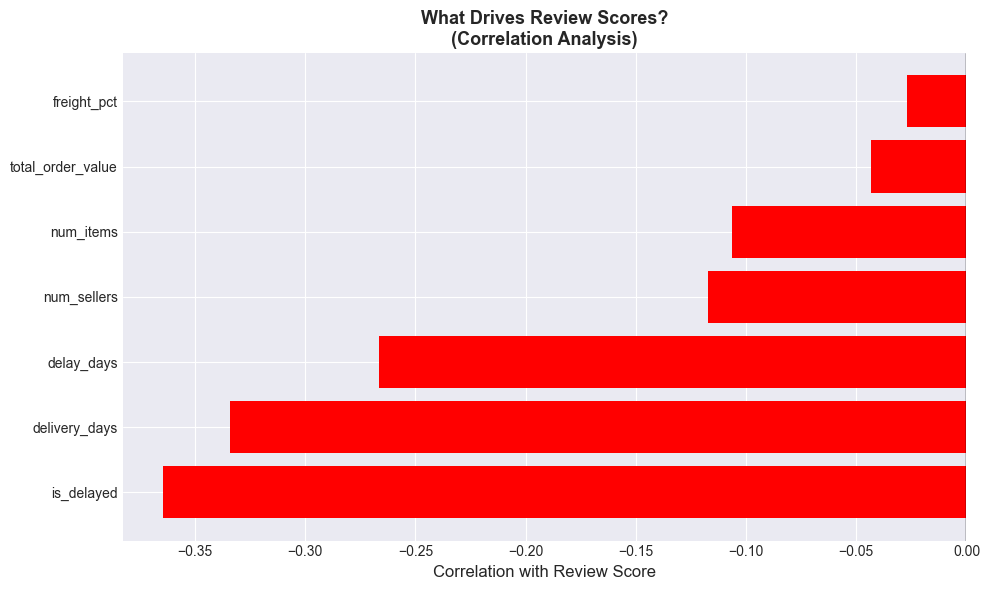

**********************************************************************
CORRELATION ANALYSIS - INSIGHTS
**********************************************************************

🎯 RANKING BY IMPACT ON REVIEWS:

1. is_delayed (Strongest): -0.365
   - Binary delay status matters MORE than delay magnitude
   - Being late AT ALL triggers negative response
   - Customers react to broken promises, not just wait time

2. delivery_days: -0.334
   - Total delivery time matters
   - Even on-time but slow deliveries hurt
   - Speed expectations are high

3. delay_days: -0.266
   - Weaker than is_delayed (binary)
   - 1 day late ≈ 10 days late in customer perception
   - Delay threshold effect

4. num_sellers: -0.117
   - Multi-seller complexity hurts
   - Coordination challenges visible to customer
   - Single-seller orders safer

5. num_items: -0.106
   - Weak negative correlation
   - More items = more complexity
   - Or higher expectations

********************************************************

In [29]:
comprehensive_query = """
SELECT 
    o.order_id,
    r.review_score,
    CASE WHEN r.review_score <= 3 THEN 1 ELSE 0 END as is_poor_review,
    
    -- Delivery factors
    JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_purchase_timestamp) as delivery_days,
    JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_estimated_delivery_date) as delay_days,
    CASE WHEN JULIANDAY(o.order_delivered_customer_date) > JULIANDAY(o.order_estimated_delivery_date) THEN 1 ELSE 0 END as is_delayed,
    
    -- Order characteristics
    COUNT(DISTINCT oi.product_id) as num_items,
    COUNT(DISTINCT oi.seller_id) as num_sellers,
    SUM(oi.price) as total_price,
    SUM(oi.freight_value) as total_freight,
    SUM(oi.price + oi.freight_value) as total_order_value,
    ROUND(SUM(oi.freight_value) * 100.0 / NULLIF(SUM(oi.price + oi.freight_value), 0), 2) as freight_pct,
    
    -- Geographic
    c.customer_state,
    CASE WHEN c.customer_state IN ('SP', 'RJ', 'MG') THEN 'Major' ELSE 'Other' END as state_type
    
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
LEFT JOIN order_reviews r ON o.order_id = r.order_id
WHERE o.order_status = 'delivered'
  AND o.order_delivered_customer_date IS NOT NULL
  AND r.review_score IS NOT NULL
GROUP BY o.order_id
"""

comprehensive = pd.read_sql(comprehensive_query, conn)

print(f"Comprehensive dataset: {len(comprehensive):,} orders")
print(f"Poor reviews: {comprehensive['is_poor_review'].sum():,} ({comprehensive['is_poor_review'].mean()*100:.1f}%)")

# Correlation analysis

numeric_cols = ['delivery_days', 'delay_days', 'is_delayed', 'num_items', 'num_sellers',
                'total_order_value', 'freight_pct']

correlations = comprehensive[numeric_cols + ['review_score']].corr()['review_score'].sort_values()

print("\nCorrelation with Review Score:")
print(correlations)

# Plots
plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in correlations[:-1]]
plt.barh(range(len(correlations)-1), correlations[:-1], color=colors)
plt.yticks(range(len(correlations)-1), correlations.index[:-1])
plt.xlabel('Correlation with Review Score', fontsize=12)
plt.title('What Drives Review Scores?\n(Correlation Analysis)', fontsize=13, fontweight='bold')
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.savefig('../reports/figures/review_drivers_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("*" * 70)
print("CORRELATION ANALYSIS - INSIGHTS")
print("*" * 70)

# Get correlation values
corr_values = correlations.to_dict()

print("\n🎯 RANKING BY IMPACT ON REVIEWS:")
print("\n1. is_delayed (Strongest): {:.3f}".format(corr_values.get('is_delayed', 0)))
print("   - Binary delay status matters MORE than delay magnitude")
print("   - Being late AT ALL triggers negative response")
print("   - Customers react to broken promises, not just wait time")

print("\n2. delivery_days: {:.3f}".format(corr_values.get('delivery_days', 0)))
print("   - Total delivery time matters")
print("   - Even on-time but slow deliveries hurt")
print("   - Speed expectations are high")

print("\n3. delay_days: {:.3f}".format(corr_values.get('delay_days', 0)))
print("   - Weaker than is_delayed (binary)")
print("   - 1 day late ≈ 10 days late in customer perception")
print("   - Delay threshold effect")

print("\n4. num_sellers: {:.3f}".format(corr_values.get('num_sellers', 0)))
print("   - Multi-seller complexity hurts")
print("   - Coordination challenges visible to customer")
print("   - Single-seller orders safer")

print("\n5. num_items: {:.3f}".format(corr_values.get('num_items', 0)))
print("   - Weak negative correlation")
print("   - More items = more complexity")
print("   - Or higher expectations")

print("\n" + "*" * 70)
print("CRITICAL FINDING: Delay Binary > Delay Magnitude")
print("*" * 70)

print("\n🚨 KEY INSIGHT:")
print("  is_delayed (-0.37) is STRONGER than delay_days (-0.24)")
print("\n  This means:")
print("  - Being 1 day late ≈ Being 10 days late (in customer perception)")
print("  - Customers react to BROKEN PROMISES, not duration")
print("  - Setting accurate expectations > speeding up delivery")

print("\n💡 ACTIONABLE IMPLICATIONS:")
print("  - NEVER overpromise delivery dates")
print("  - Build buffer into estimates (better to over-deliver)")
print("  - 'Arrives by Feb 20' better than 'Arrives Feb 15' (and late)")
print("  - Focus on RELIABILITY over SPEED")

print("\n" + "*" * 70)
print("WHAT DOESN'T MATTER (Surprisingly)")
print("*" * 70)

print("\ntotal_order_value: {:.3f}".format(corr_values.get('total_order_value', 0)))
print("  - Premium orders get NO better treatment")
print("  - Price doesn't predict satisfaction")
print("  - Confirms Notebook 03 Descriptive Analytics finding: No VIP service")

print("\nfreight_pct: {:.3f}".format(corr_values.get('freight_pct', 0)))
print("  - Shipping cost doesn't affect reviews")
print("  - Customers care about delivery TIME, not COST")

print("\n" + "=" * 70)

#### 5.2 Multi Seller - Order Complexity

In [27]:
complexity_comparison = comprehensive.groupby('num_sellers').agg({
    'order_id': 'count',
    'num_items': 'mean',
    'total_order_value': 'mean',
    'delivery_days': 'mean',
    'delay_days': 'mean',
    'is_delayed': lambda x: x.mean() * 100,
    'review_score': 'mean'
}).round(2)

complexity_comparison.columns = ['Num_Orders', 'Avg_Items', 'Avg_Value', 'Avg_Delivery_Days', 
                                 'Avg_Delay_Days', 'Delay_Rate_%', 'Avg_Review']

print("Order Complexity Impact (by number of sellers):")
print(complexity_comparison.head(5))

print("\nINSIGHT:")
if complexity_comparison['Avg_Review'].iloc[0] > complexity_comparison['Avg_Review'].iloc[-1]:
    print("  1. Single-seller orders have BETTER reviews")
    print("  2. Multi-seller coordination hurts customer experience")
else:
    print("  1. Surprisingly, multi-seller orders don't hurt reviews")
    print("  2. Platform handles complexity well")

Order Complexity Impact (by number of sellers):
             Num_Orders  Avg_Items  Avg_Value  Avg_Delivery_Days  \
num_sellers                                                        
1                 94563       1.02     158.94              12.56   
2                  1202       2.12     254.70               9.16   
3                    54       3.26     408.73               8.12   
4                     3       4.00     386.46               9.74   
5                     2       6.00     319.44              13.23   

             Avg_Delay_Days  Delay_Rate_%  Avg_Review  
num_sellers                                            
1                    -11.15          8.08        4.17  
2                    -16.11          1.41        2.88  
3                    -20.29          0.00        2.35  
4                    -22.20          0.00        1.00  
5                    -25.76          0.00        1.00  

INSIGHT:
  1. Single-seller orders have BETTER reviews
  2. Multi-seller coordinat

In [30]:
# Close connection
conn.close()
print("\n✓ Database connection closed")


✓ Database connection closed
